In [241]:
import math

In [263]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data}, {self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            # += to accumulate the gradients
            # if we only do = then it will override the previous gradients
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [264]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any  value in graph create a rantangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is result of some operation then create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

In [244]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.88137, label='b')

# x1*w1 + x2*w2 + b 
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

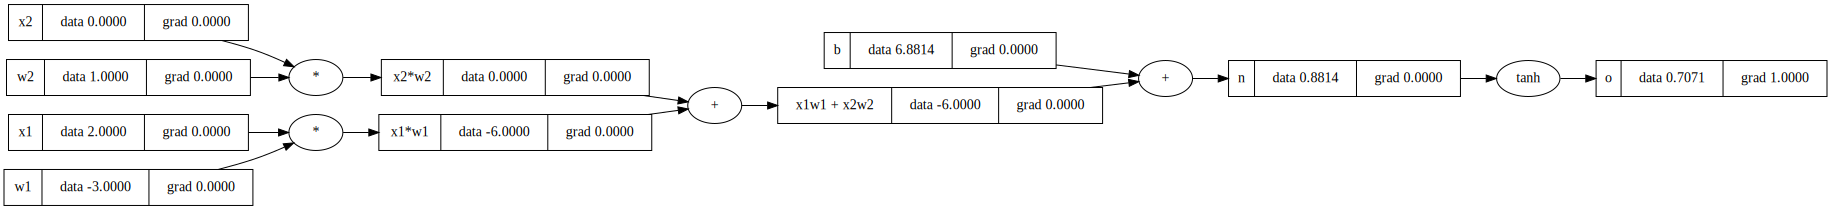

In [245]:
o.grad = 1.0
draw_dot(o)

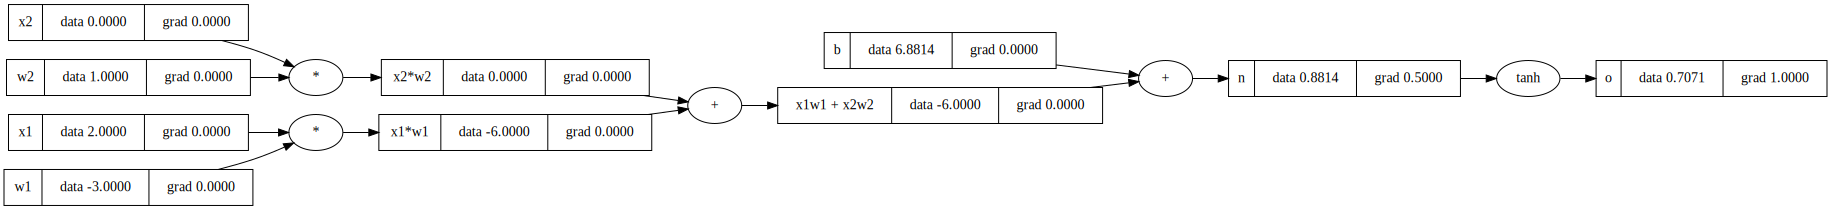

In [246]:
o._backward()
draw_dot(o)

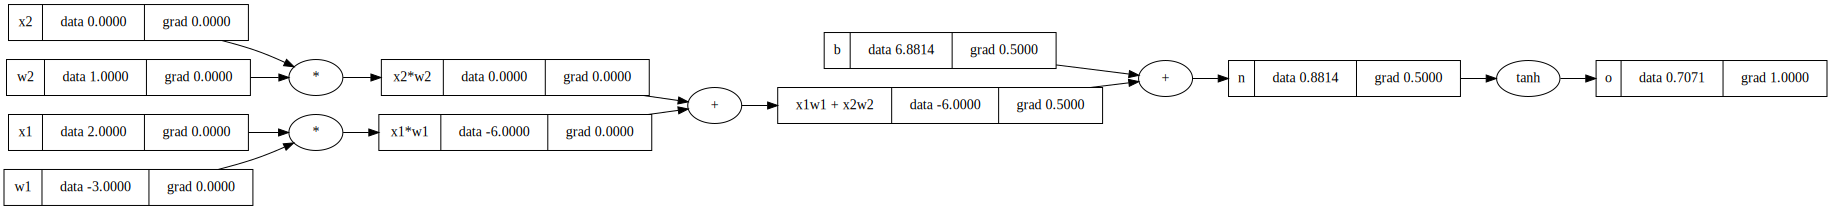

In [247]:
n._backward()
draw_dot(o)

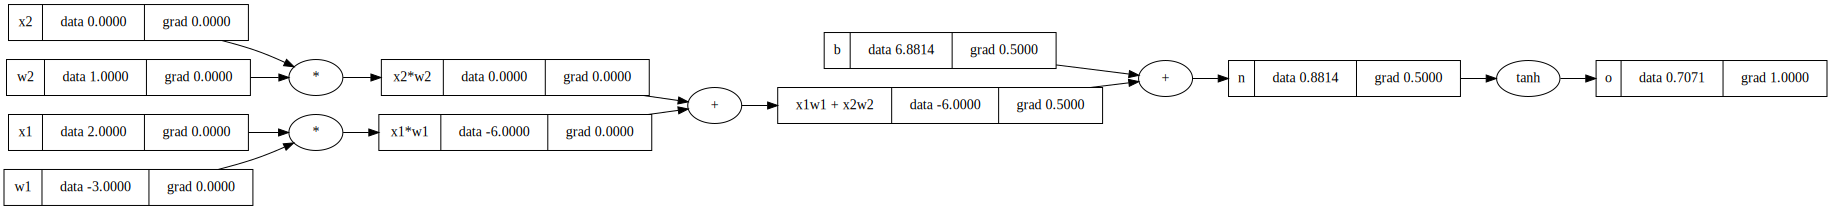

In [248]:
b._backward()
draw_dot(o)

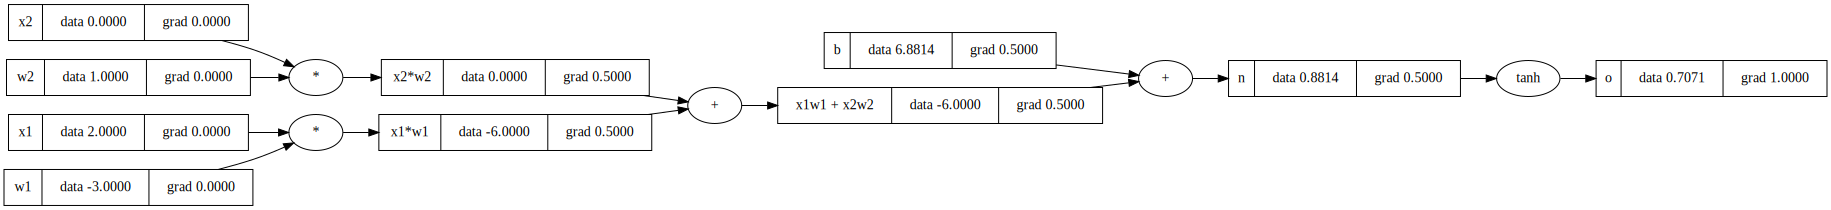

In [249]:
x1w1x2w2._backward()
draw_dot(o)

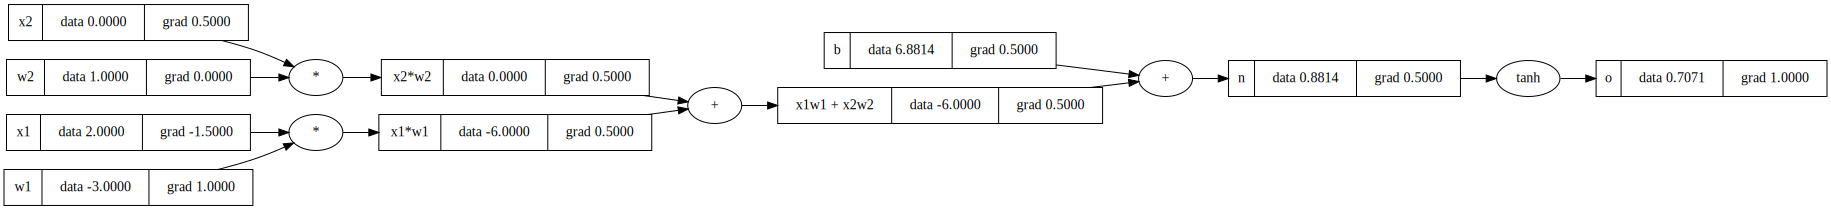

In [250]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

### Automating the backward movement using Topological sort

In [251]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2.0, x1),
 Value(data=-3.0, w1),
 Value(data=-6.0, x1*w1),
 Value(data=0.0, x2),
 Value(data=1.0, w2),
 Value(data=0.0, x2*w2),
 Value(data=-6.0, x1w1 + x2w2),
 Value(data=6.88137, b),
 Value(data=0.8813700000000004, n),
 Value(data=0.7071049876722272, o)]

In [252]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

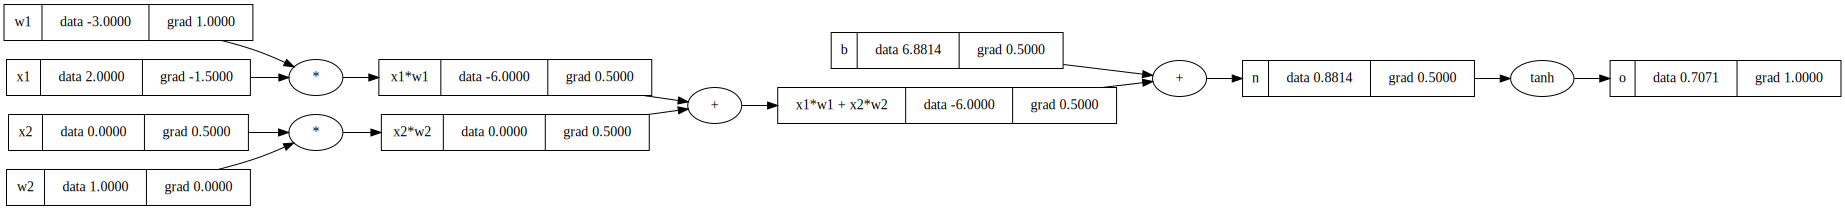

In [253]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
    for child in v._prev:
        build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

### After adding the whole topological sort functionality into our Value object

In [254]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Adding bias b
b = Value(6.88137, label='b')

# x1*w1 + x2*w2 + b 
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

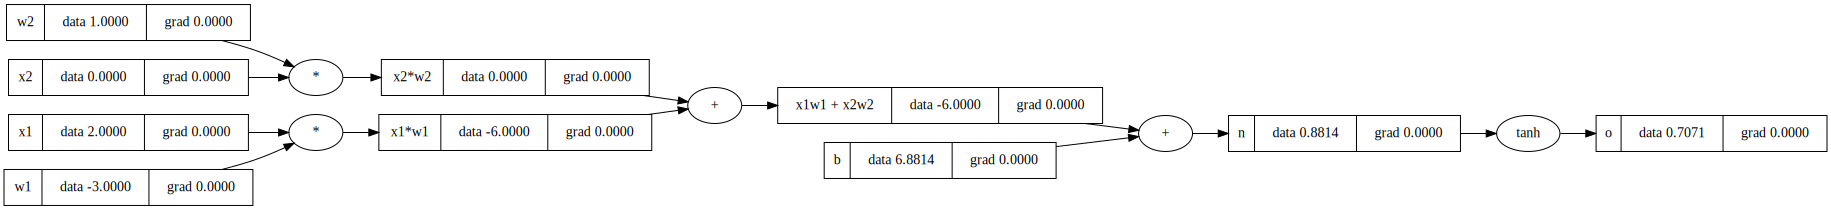

In [255]:
draw_dot(o)

In [256]:
o.backward()

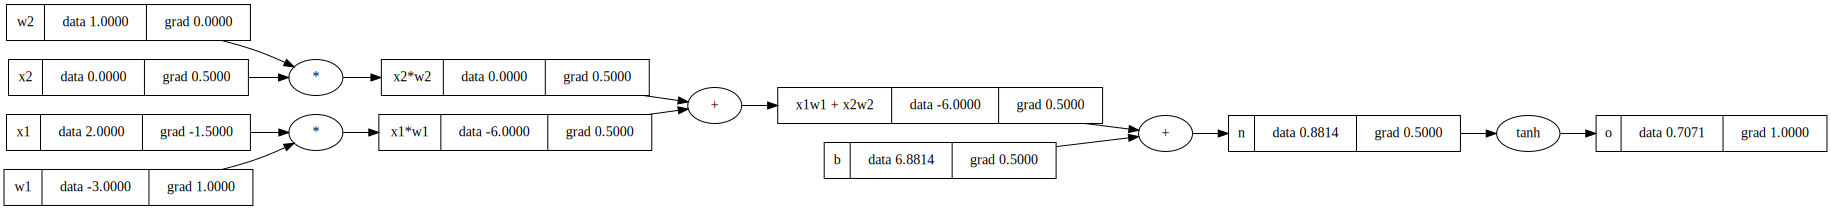

In [257]:
draw_dot(o)